In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import LogRegAC.utilsAC as utilsAC

In [37]:
data = pd.read_csv('data.csv', header=None)
print(data.shape)
data.head()

(200, 3)


,0,1,2
0,6,32,1
1,26,39,1
2,2,38,1
3,25,39,1
4,3,35,1


In [38]:
data_x = data.iloc[:, 0:-1]
data_y = data.iloc[:, -1]

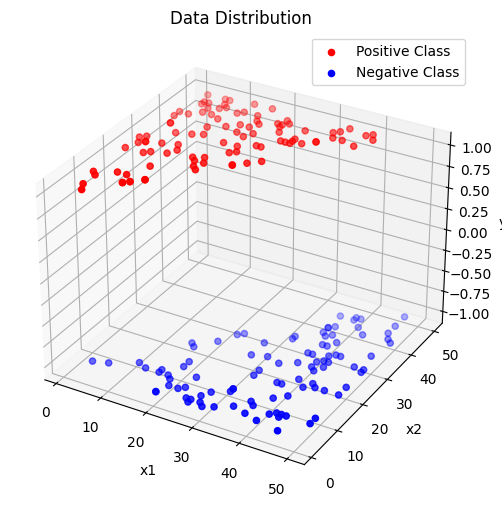

In [39]:
plt.figure(figsize=(10, 6))
ax = plt.axes(projection='3d')
ax.scatter3D(
    [data_x.iloc[i, 0] for i in range(len(data_x)) if data_y.iloc[i] == 1], 
    [data_x.iloc[i, 1] for i in range(len(data_x)) if data_y.iloc[i] == 1], 
    [i for i in data_y if i == 1], c='red', label='Positive Class')
ax.scatter3D(
    [data_x.iloc[i, 0] for i in range(len(data_x)) if data_y.iloc[i] != 1], 
    [data_x.iloc[i, 1] for i in range(len(data_x)) if data_y.iloc[i] != 1], 
    [i for i in data_y if i != 1], c='blue', label='Negative Class')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')
plt.legend()
plt.title('Data Distribution')
plt.show()

In [40]:
train_x, train_y, test_x, test_y = utilsAC.splitTrainTest(data_x, data_y, 0.8)
train_x, train_min, train_max = utilsAC.normMinMax(train_x, mode='train')
test_x = utilsAC.normMinMax(test_x, mode='test', train_min=train_min, train_max=train_max)